In [9]:
from tqdm.auto import tqdm
import json
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from google.cloud import bigquery
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

my_cmap = plt.get_cmap("Paired")

In [10]:
BCODES_PATHS = "/home/franci/Downloads/data/b_codes.json"
b_codes = json.load(open(BCODES_PATHS))[0]
print("Found {} Codes".format(len(b_codes)))

Found 601 Codes


In [11]:
dataset_df = pd.read_csv("dataset_df.csv")
dataset_df

,station_id,id_gepo,station_lat,station_lon,station_nome,station_H_piano_strada,station_H_mslm,arkimet_id,arkimet_lat,arkimet_lon,...,TEMP_std,PREC_min,PREC_max,PREC_mean,PREC_std,pol_var_id,reftime,pol_value,modified,pol_var_descr
0,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48026,2021-01-03 00:00:00+00:00,0.00,None,"Mirtacee_Mirtacee indistinte, POLLEN/M**3"
1,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48029,2021-01-03 00:00:00+00:00,0.00,None,"Ulmacee_Ulmacee indistinte, POLLEN/M**3"
2,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48025,2021-01-03 00:00:00+00:00,0.00,None,"Euphorbiacee_Euforbiacee indistinte, POLLEN/M**3"
3,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48024,2021-01-03 00:00:00+00:00,0.00,None,"Poligonacee_Poligonacee indistinte, POLLEN/M**3"
4,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48034,2021-01-03 00:00:00+00:00,0.00,None,"Salicacee_Pioppo, POLLEN/M**3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100810,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,2.3,0.0,0.0,0.0,0.0,B48008,2021-12-30 00:00:00+00:00,0.43,None,"Corilacee_Nocciolo, POLLEN/M**3"
100811,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,2.3,0.0,0.0,0.0,0.0,B48034,2021-12-30 00:00:00+00:00,0.00,None,"Salicacee_Pioppo, POLLEN/M**3"
100812,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,2.3,0.0,0.0,0.0,0.0,B48041,2021-12-30 00:00:00+00:00,0.00,None,"Spore fungine_Stemphylium, POLLEN/M**3"
100813,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,2.3,0.0,0.0,0.0,0.0,B48023,2021-12-30 00:00:00+00:00,0.00,None,Chenopodiacee - Amarantacee Indistinte_Chenopo...


___

In [12]:
# TODO:
# 1. estrazione feature da arkimet (1 valore al gg min,max,mean,std, etc)
# 2. correlazione tra concentrazione poldat con 1. e meteo
# 3. clustering su specie da poldat
# 4. capire se e come usare lat/lon
# tempo allineato o traslato di 24h?

# . Clustering species

In [13]:
import seaborn as sns
from collections import Counter
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

In [126]:
dataset_df.dropna(inplace=True)
dataset_df.iloc[:3].T

,0,1,2
station_id,1,1,1
id_gepo,4181,4181,4181
station_lat,44.4914,44.4914,44.4914
station_lon,11.3694,11.3694,11.3694
station_nome,Bologna,Bologna,Bologna
station_H_piano_strada,80.0,80.0,80.0
station_H_mslm,101.0,101.0,101.0
arkimet_id,Bologna urbana,Bologna urbana,Bologna urbana
arkimet_lat,44.5008,44.5008,44.5008
arkimet_lon,11.3288,11.3288,11.3288


In [164]:
dataset_df.groupby("pol_var_id")["pol_var_id"].count()

pol_var_id
B48001    2582
B48002    2582
B48003    2582
B48005    2582
B48006    2582
B48007    2582
B48008    2582
B48011    2582
B48012    2582
B48013    2582
B48015    2582
B48016    2582
B48017    2582
B48018    2582
B48019    2582
B48021    2582
B48023    2582
B48024    2582
B48025    2582
B48026    2582
B48029    2582
B48030    2582
B48031    2582
B48032    2582
B48033    2582
B48034    2582
B48036    2582
B48037    2582
B48038    2582
B48039    2582
B48041    2582
B48044    2582
B48045    2582
B48066    2582
B48077    2582
B48079    2582
B48080    2582
B48081    2582
B48082    2582
Name: pol_var_id, dtype: int64

In [127]:
label = "pol_var_id"

species_keys = [
    'B13011_min',
    'B13011_max',
    'B13011_mean',
    'B13011_std',
    'B14198_min',
    'B14198_max',
    'B14198_mean',
    'B14198_std',
    'TEMP_min',
    'TEMP_max',
    'TEMP_mean',
    'TEMP_std',
    'PREC_min',
    'PREC_max',
    'PREC_mean',
    'PREC_std',
    'pol_value'
]

# df = dataset_df[[label] + species_keys].copy()
# df.dropna(inplace=True)
# df

In [128]:
dataset_df.pol_var_id.unique(), dataset_df.pol_var_id.nunique()

(array(['B48026', 'B48029', 'B48025', 'B48024', 'B48034', 'B48033',
        'B48037', 'B48036', 'B48030', 'B48032', 'B48031', 'B48021',
        'B48008', 'B48007', 'B48011', 'B48003', 'B48001', 'B48002',
        'B48006', 'B48005', 'B48018', 'B48017', 'B48039', 'B48023',
        'B48019', 'B48013', 'B48012', 'B48016', 'B48015', 'B48066',
        'B48045', 'B48080', 'B48041', 'B48082', 'B48079', 'B48044',
        'B48077', 'B48038', 'B48081'], dtype=object),
 39)

# Determine number of clusters

## 1. WCSS on full dataset

In [129]:
X = dataset_df[species_keys].copy()

In [130]:
wcss = []
cluster_ranges = list(range(2, 12))
for i in tqdm(cluster_ranges):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)

    wcss.append(kmeans.inertia_)

  0%|          | 0/10 [00:00<?, ?it/s]

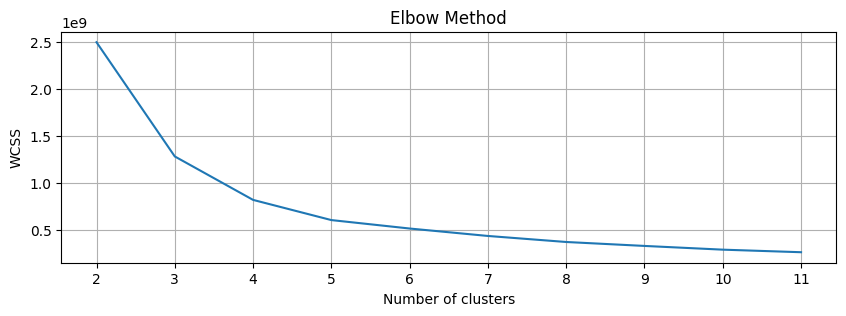

In [131]:
plt.figure(figsize=(10,3))
plt.plot(cluster_ranges, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(cluster_ranges)
plt.grid()
plt.show()

In [132]:
# elbow at n clusters
n_optimal = 5

### 1.2 Silhouete analysis

  0%|          | 0/4 [00:00<?, ?it/s]

For n_clusters = 3 The average silhouette_score is : 0.5672967022015093
For n_clusters = 5 The average silhouette_score is : 0.5015792446870271
For n_clusters = 7 The average silhouette_score is : 0.43804362705652194
For n_clusters = 9 The average silhouette_score is : 0.3959051289635777


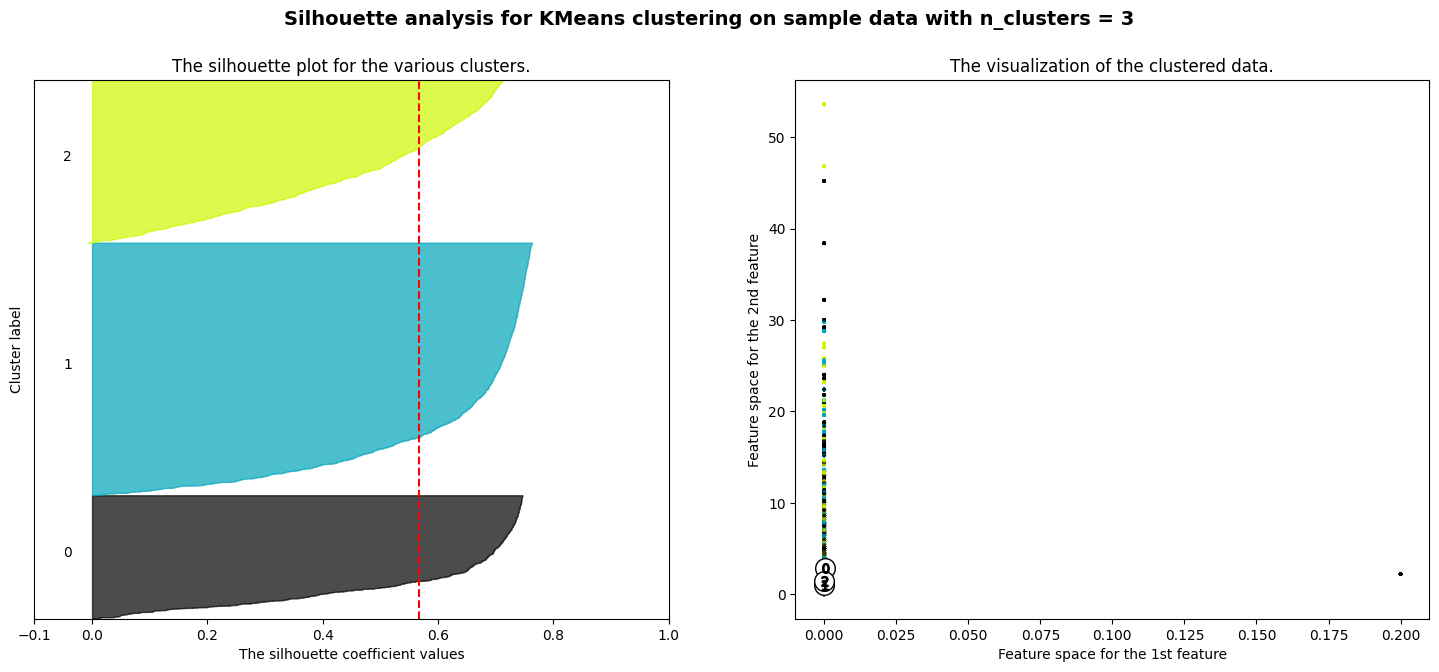

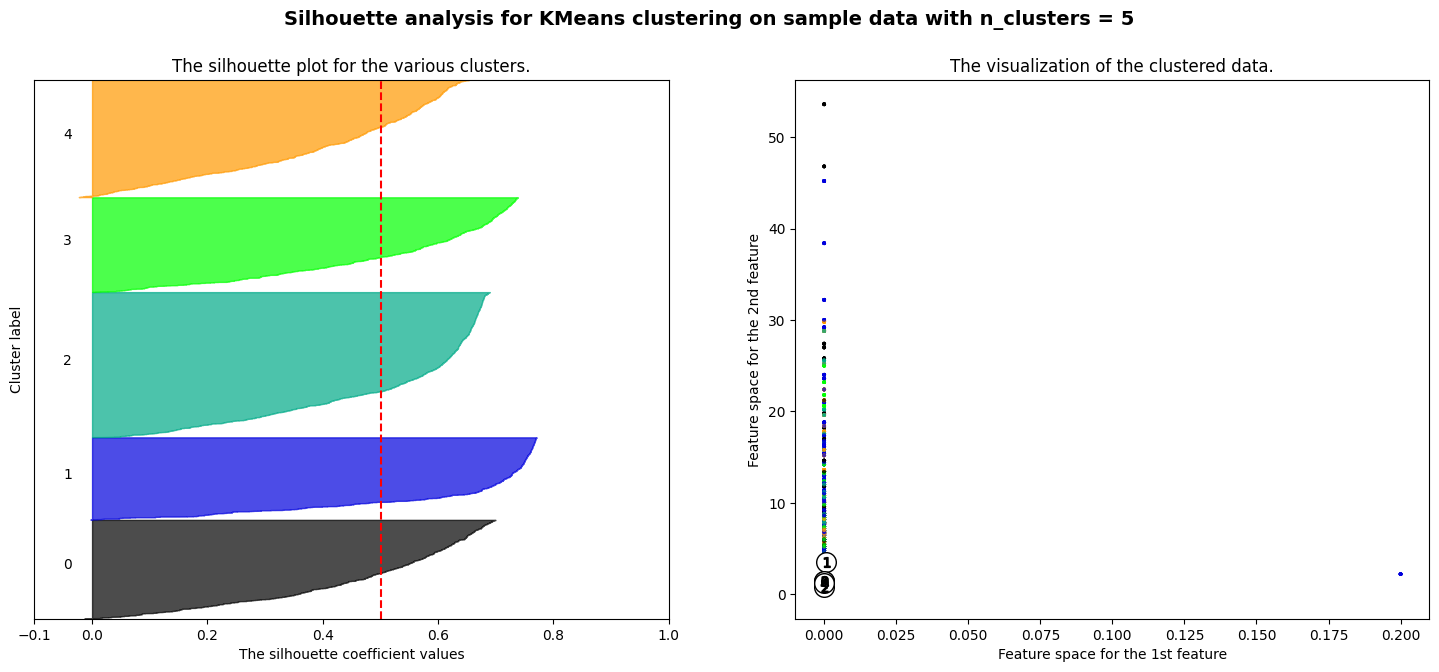

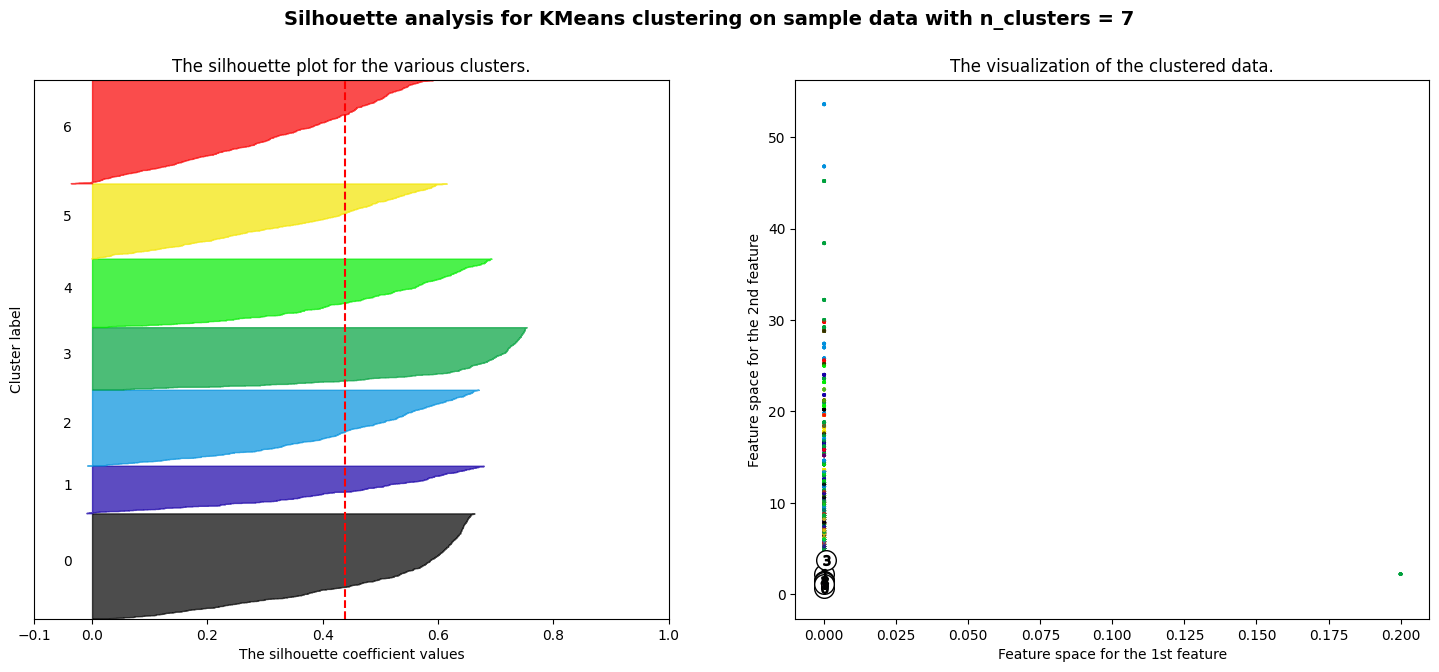

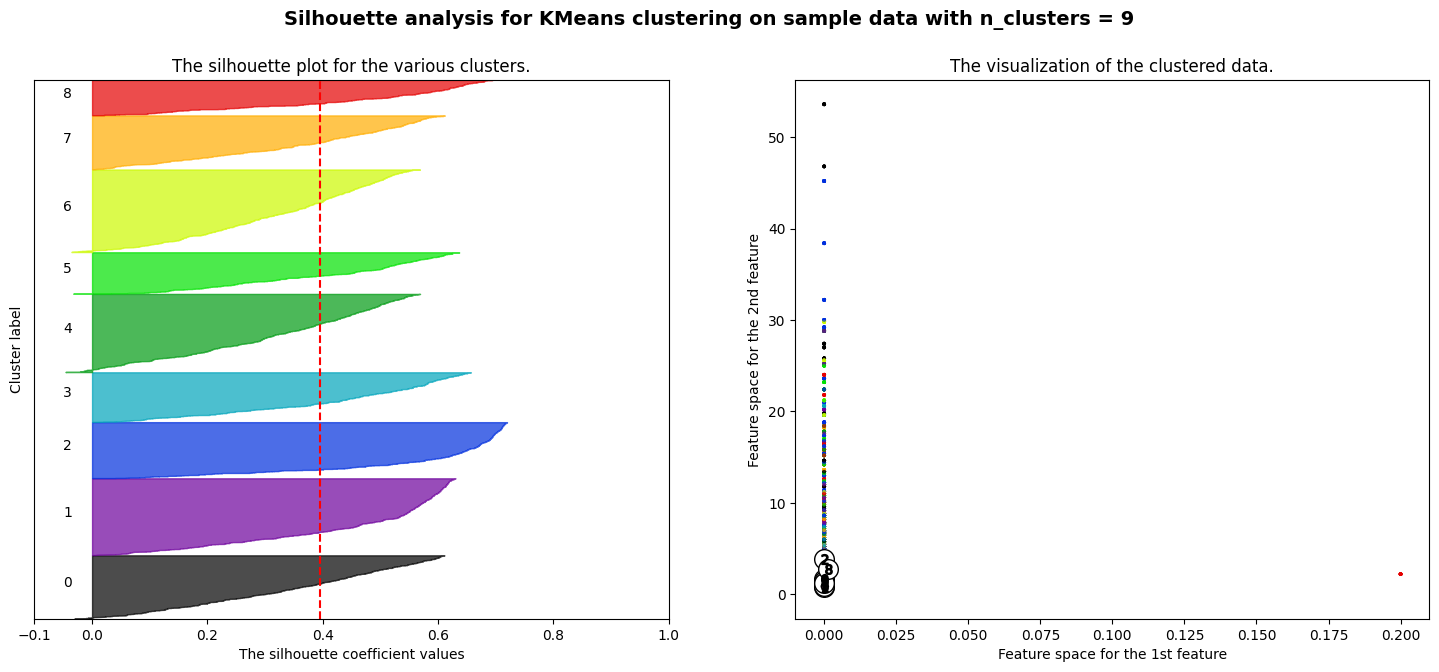

In [133]:
X = X.sample(frac=.25).values

for n_clusters in tqdm(range(3, 10, 2)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto")
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :",silhouette_avg,)

    y_lower = 10
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold",)

plt.show()

# 2. Determine number of cluster using PCA on dataset

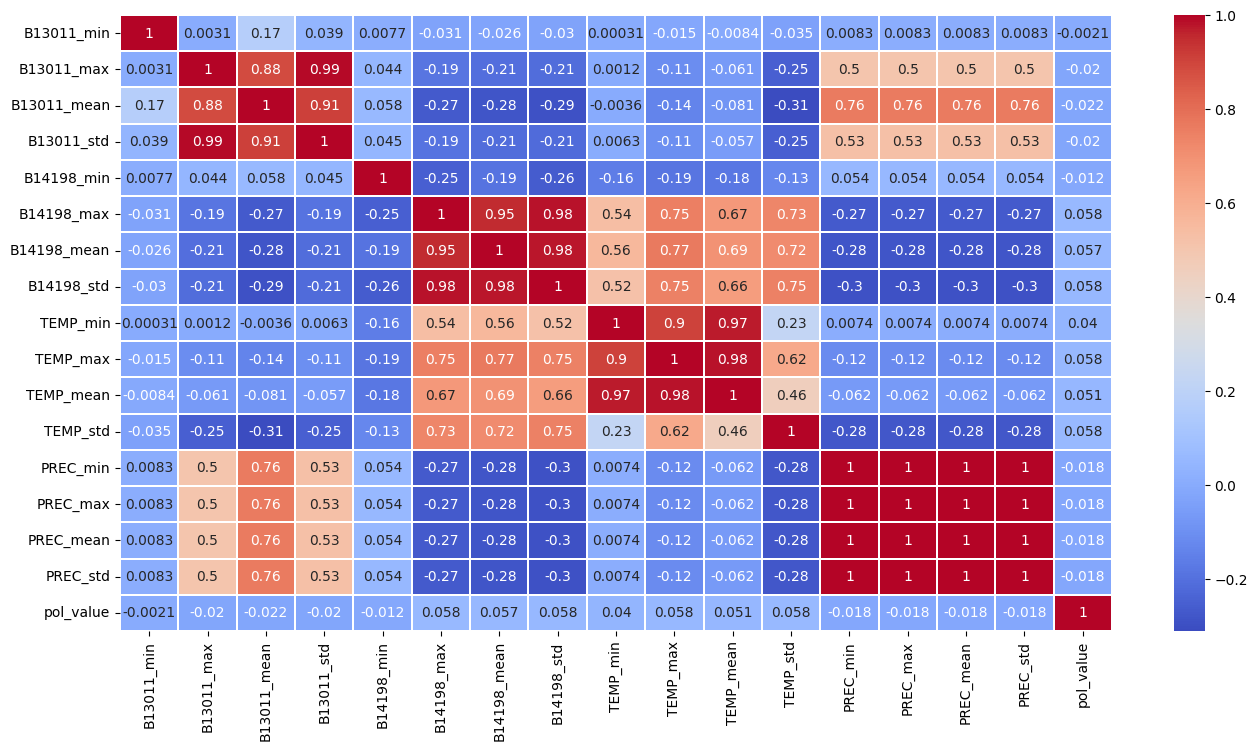

In [165]:
X = dataset_df[species_keys].copy()
df_corr = X.corr(min_periods=3)

plt.figure(figsize=(16,8))
sns.heatmap(df_corr, cmap='coolwarm', linewidths=.2, annot=True);

with 3 components explained variance ratio is 0.9963608955054855


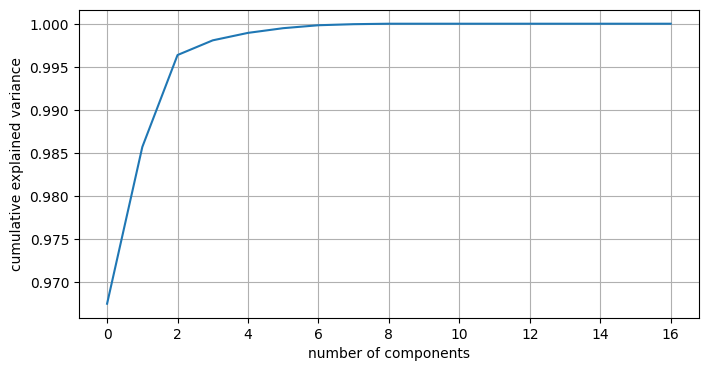

In [136]:
X = dataset_df[species_keys].copy()

pca = PCA().fit(X)
variance = 0
components = 0
for val in pca.explained_variance_ratio_:
    variance += val
    components += 1
    if variance >= 0.99:
        print('with {} components explained variance ratio is {}'.format(components, variance))
        break

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid();

In [137]:
n_components = components
n_components

3

In [138]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

X_pca.shape

(100698, 3)

In [139]:
idxs = np.random.choice(X_pca.shape[0], int(X_pca.shape[0]*.25), replace=False)
X_pca[idxs].shape

(25174, 3)

### 2.2 Silhouete analysis

  0%|          | 0/4 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.636649438349764
For n_clusters = 3 The average silhouette_score is : 0.5741283373243607
For n_clusters = 4 The average silhouette_score is : 0.5571648213136299
For n_clusters = 5 The average silhouette_score is : 0.5218424815871049


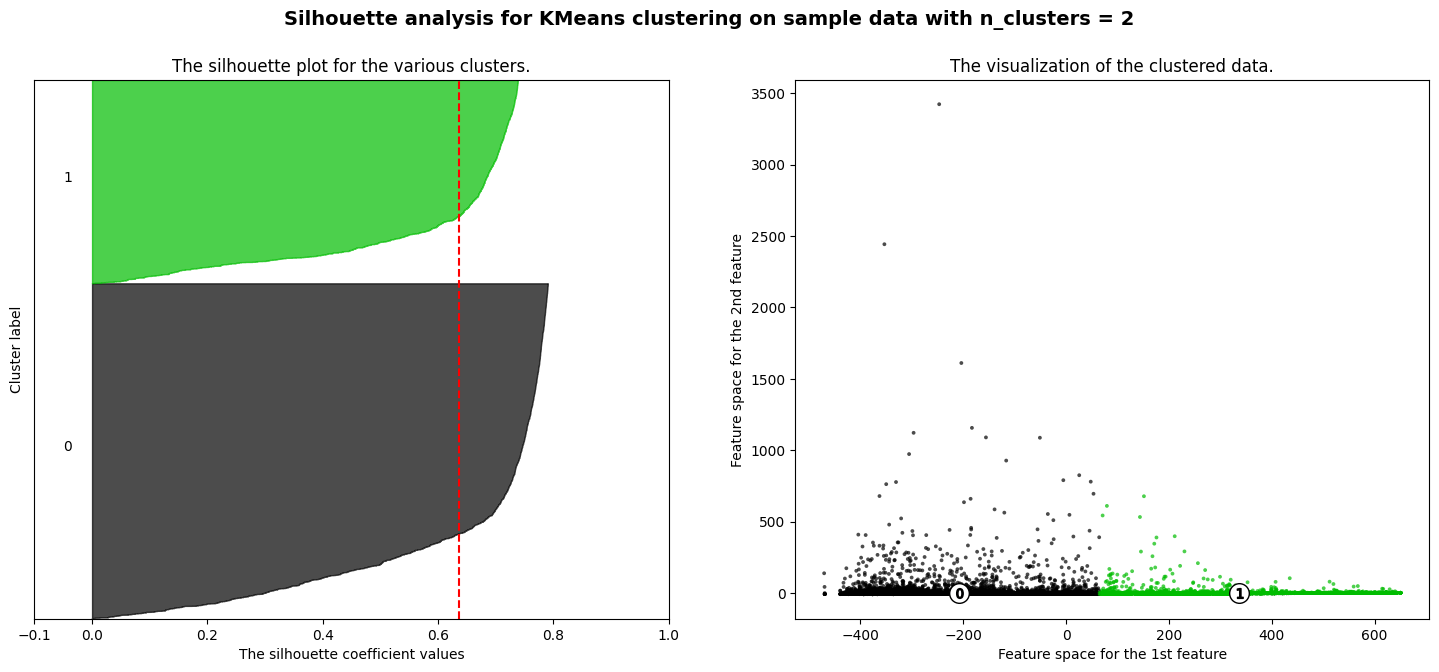

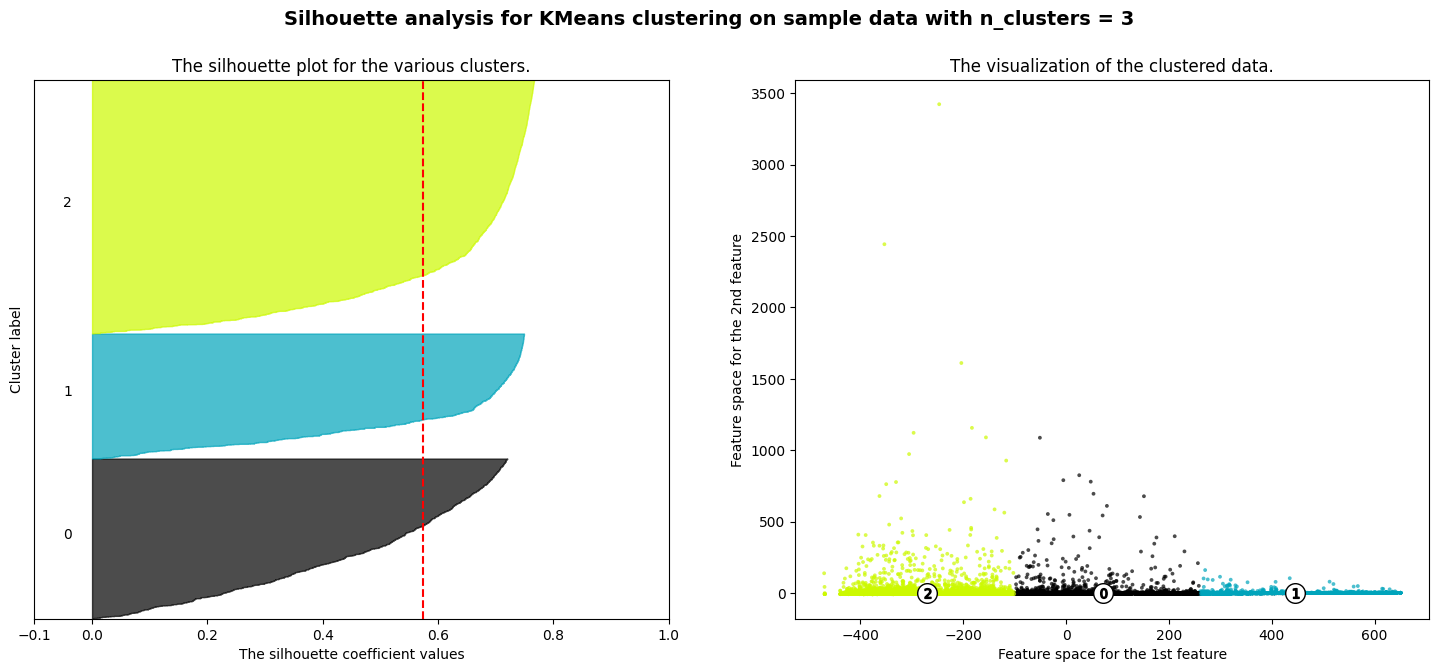

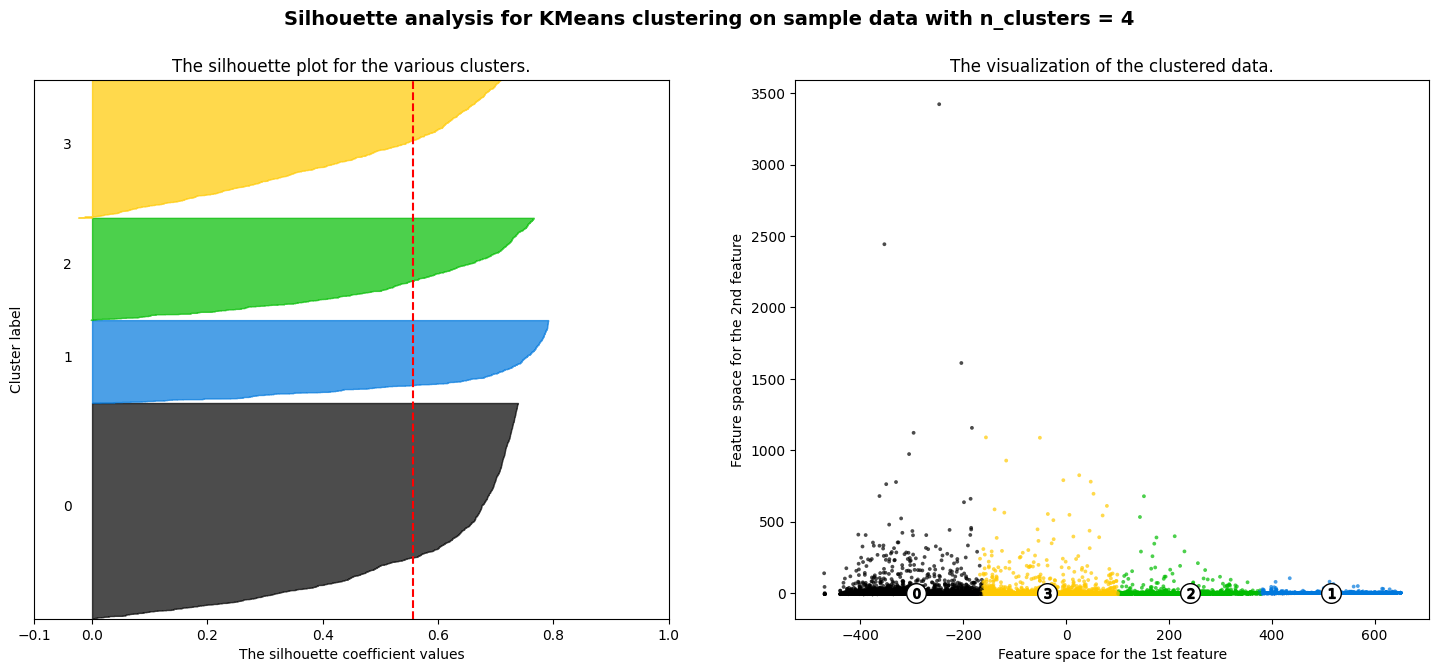

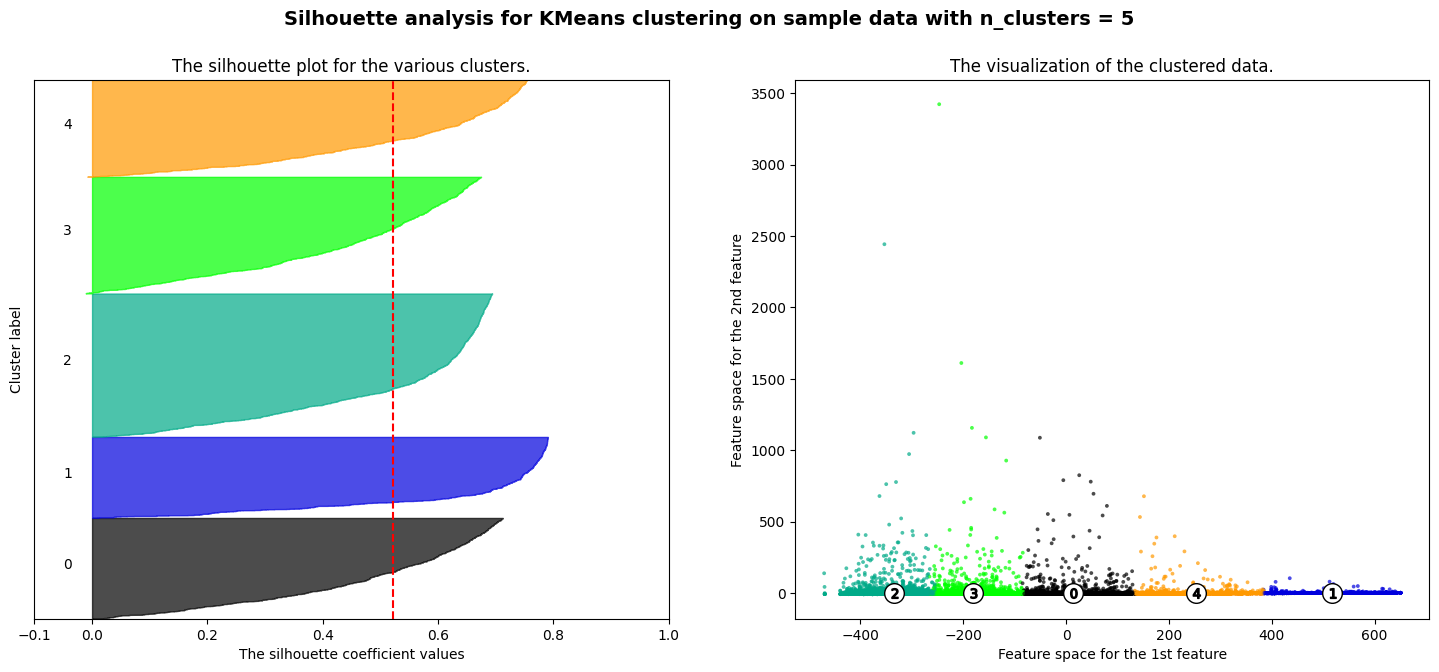

In [140]:
X = X_pca[idxs]

for n_clusters in tqdm(range(2, 6)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2))
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto")
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :",silhouette_avg,)

    y_lower = 10
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold",)

plt.show()

In [143]:
kmeans = KMeans(n_clusters=2)

X = dataset_df[species_keys].values
kmeans.fit(X)

labels = kmeans.labels_
dataset_df["label"] = labels

Counter(labels)

Counter({0: 38334, 1: 62364})

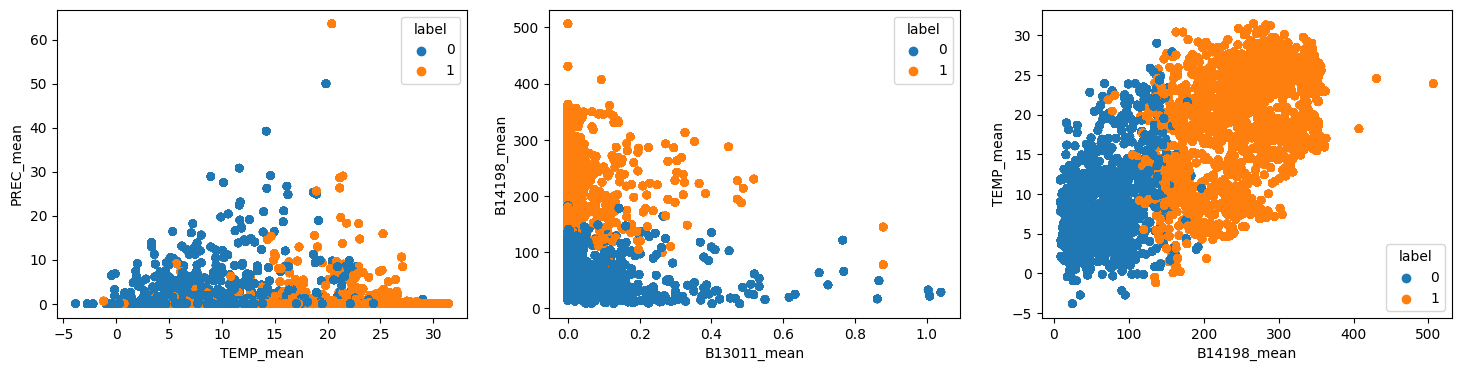

In [145]:
f, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.scatterplot(x='TEMP_mean', y='PREC_mean', data=dataset_df, hue='label', ec=None, ax=axs[0]);
sns.scatterplot(x='B13011_mean', y='B14198_mean', data=dataset_df, hue='label', ec=None, ax=axs[1]);
sns.scatterplot(x='B14198_mean', y='TEMP_mean', data=dataset_df, hue='label', ec=None, ax=axs[2]);

## 2.3 Which species have been grouped by

In [146]:
### Assign cluster labels
dataset_df["label"] = labels

### Count species, cluster number
species_groups = dataset_df.groupby(["pol_var_id", "label"]).count()

### Sort by count and keep most common cluster
species_groups = species_groups.sort_values("pol_var_id")
species_groups = species_groups.groupby(level=0).tail(1)

species_groups = species_groups.index.values
species_groups

array([('B48001', 1), ('B48002', 1), ('B48003', 1), ('B48005', 1),
       ('B48006', 0), ('B48007', 1), ('B48008', 1), ('B48011', 1),
       ('B48012', 1), ('B48013', 0), ('B48015', 1), ('B48016', 1),
       ('B48017', 1), ('B48018', 0), ('B48019', 0), ('B48021', 1),
       ('B48023', 1), ('B48024', 1), ('B48025', 0), ('B48026', 0),
       ('B48029', 1), ('B48030', 1), ('B48031', 1), ('B48032', 1),
       ('B48033', 0), ('B48034', 1), ('B48036', 1), ('B48037', 1),
       ('B48038', 0), ('B48039', 0), ('B48041', 1), ('B48044', 1),
       ('B48045', 1), ('B48066', 1), ('B48077', 0), ('B48079', 1),
       ('B48080', 1), ('B48081', 1), ('B48082', 1)], dtype=object)

In [147]:
### Reassign cluster
species_groups = dict(species_groups)
dataset_df.label = dataset_df.pol_var_id.map(species_groups)

species_groups = dataset_df.groupby("label")["pol_var_descr"].apply(list)
species_groups = {key:sorted(set(values)) for key,values in dict(species_groups).items()}

# display
output1 = widgets.Output()
with output1: display(species_groups[0])
output2 = widgets.Output()
with output2: display(species_groups[1])

two_columns = widgets.HBox([output1, output2])
display(two_columns)

# 3. Clusterize without b_code features

In [148]:
sub_features = list(filter(lambda f: not f.startswith("B"), species_keys))
sub_features

['TEMP_min',
 'TEMP_max',
 'TEMP_mean',
 'TEMP_std',
 'PREC_min',
 'PREC_max',
 'PREC_mean',
 'PREC_std',
 'pol_value']

In [149]:
X = dataset_df[sub_features].copy().values
X

array([[2.6 , 7.6 , 5.1 , ..., 3.2 , 3.2 , 0.  ],
       [2.6 , 7.6 , 5.1 , ..., 3.2 , 3.2 , 0.  ],
       [2.6 , 7.6 , 5.1 , ..., 3.2 , 3.2 , 0.  ],
       ...,
       [2.4 , 7.  , 4.7 , ..., 0.  , 0.  , 0.  ],
       [2.4 , 7.  , 4.7 , ..., 0.  , 0.  , 0.  ],
       [2.4 , 7.  , 4.7 , ..., 0.  , 0.  , 0.43]])

In [150]:
idxs = np.random.choice(X.shape[0], int(X.shape[0]*.25), replace=False)
X = X[idxs]

X.shape

(25174, 9)

  0%|          | 0/4 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.9785187238923028
For n_clusters = 3 The average silhouette_score is : 0.47183577630212575
For n_clusters = 4 The average silhouette_score is : 0.4807247172673344
For n_clusters = 5 The average silhouette_score is : 0.49062486481200135


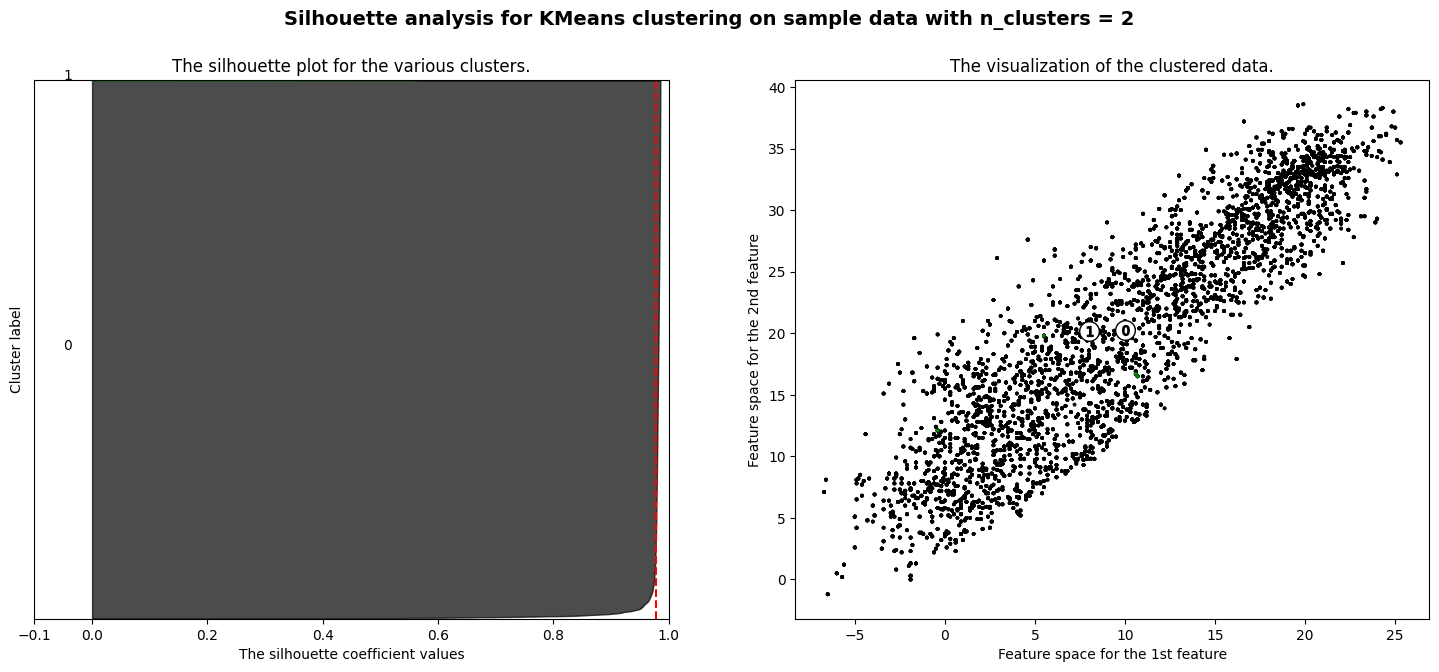

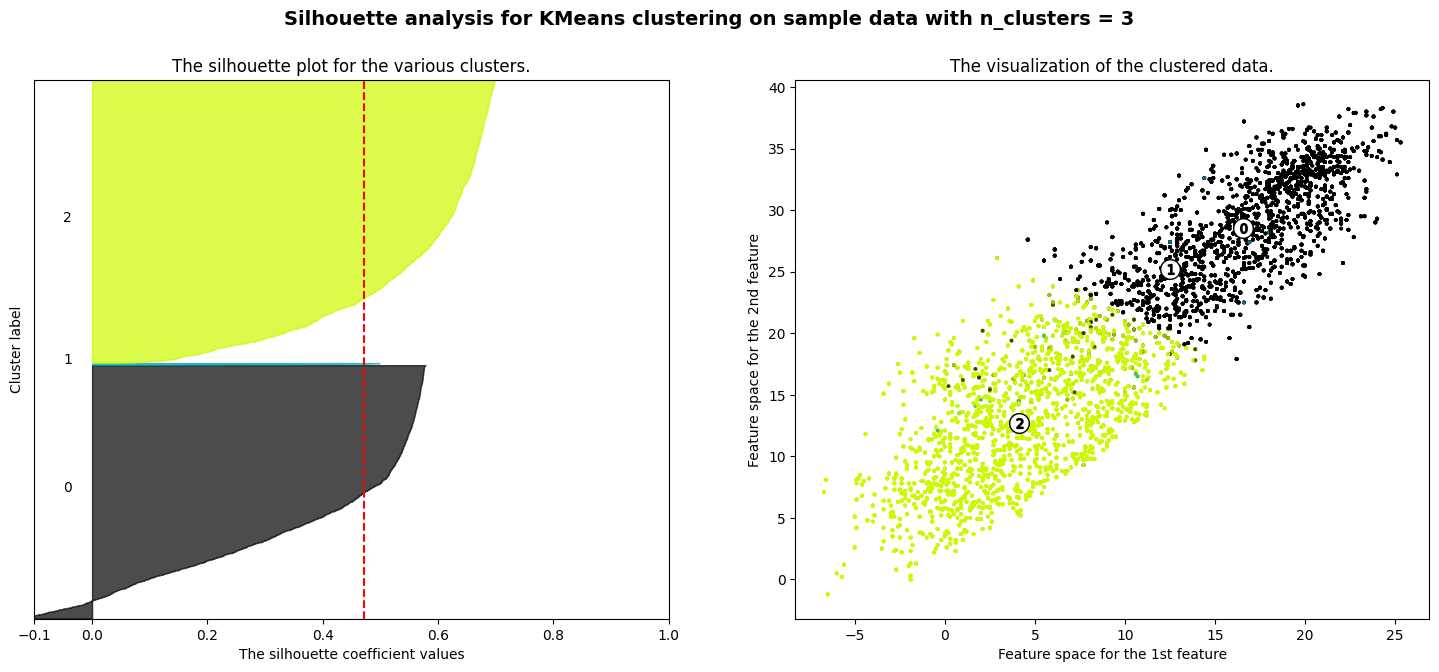

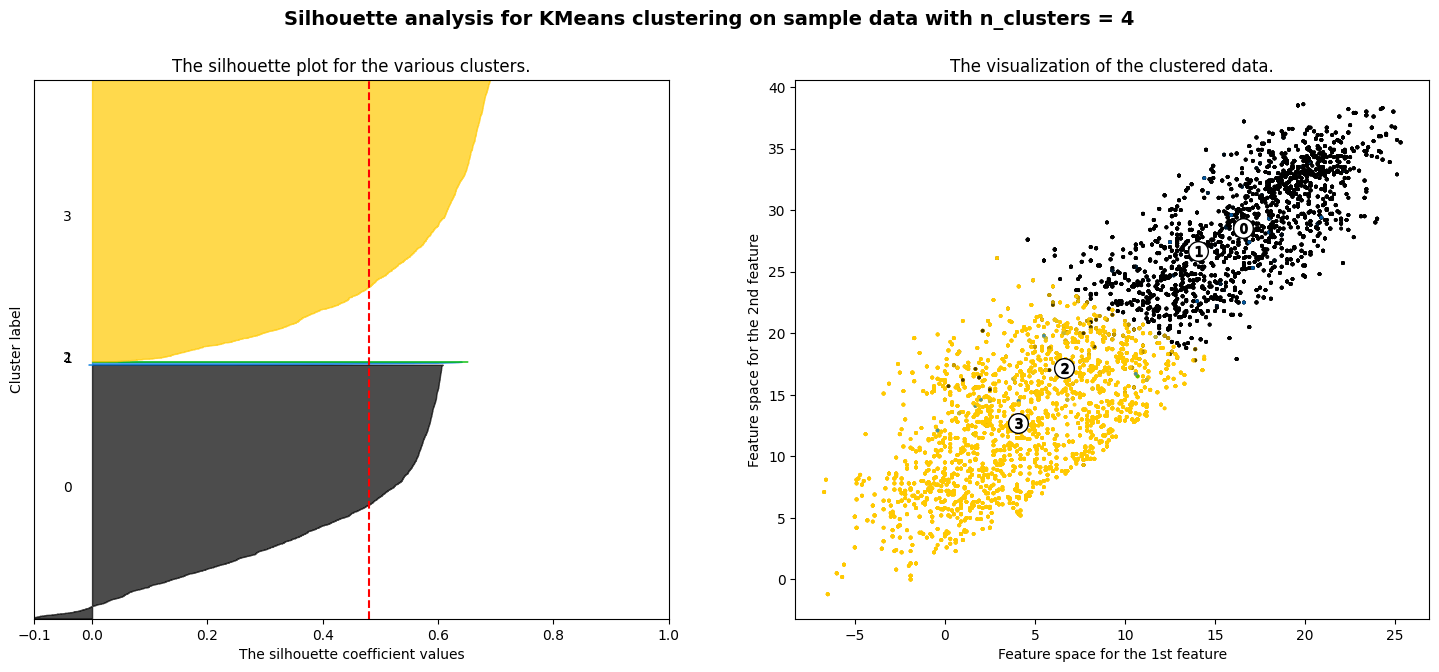

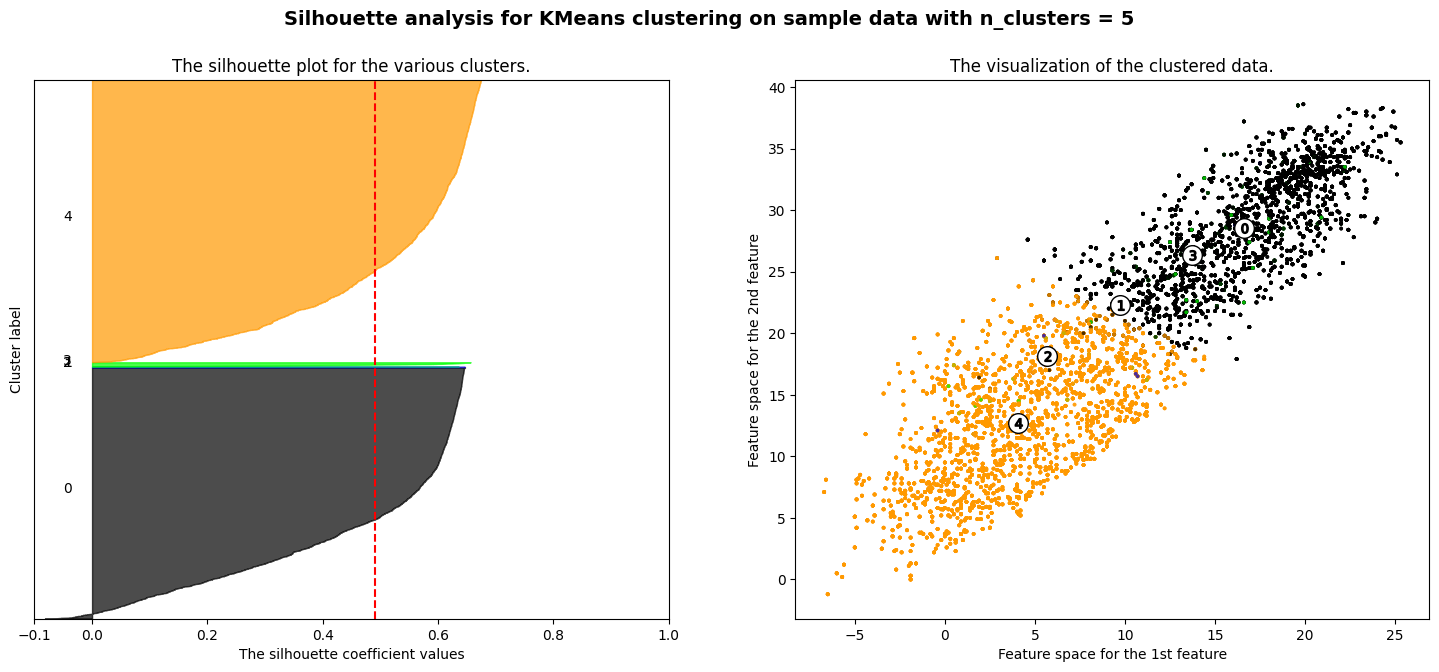

In [151]:
for n_clusters in tqdm(range(2, 6)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2))
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto")
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :",silhouette_avg,)

    y_lower = 10
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold",)

plt.show()

In [152]:
kmeans = KMeans(n_clusters=2)

X = dataset_df[sub_features].copy().values
kmeans.fit(X)

labels = kmeans.labels_
dataset_df["label"] = labels

Counter(labels)

Counter({0: 100274, 1: 424})

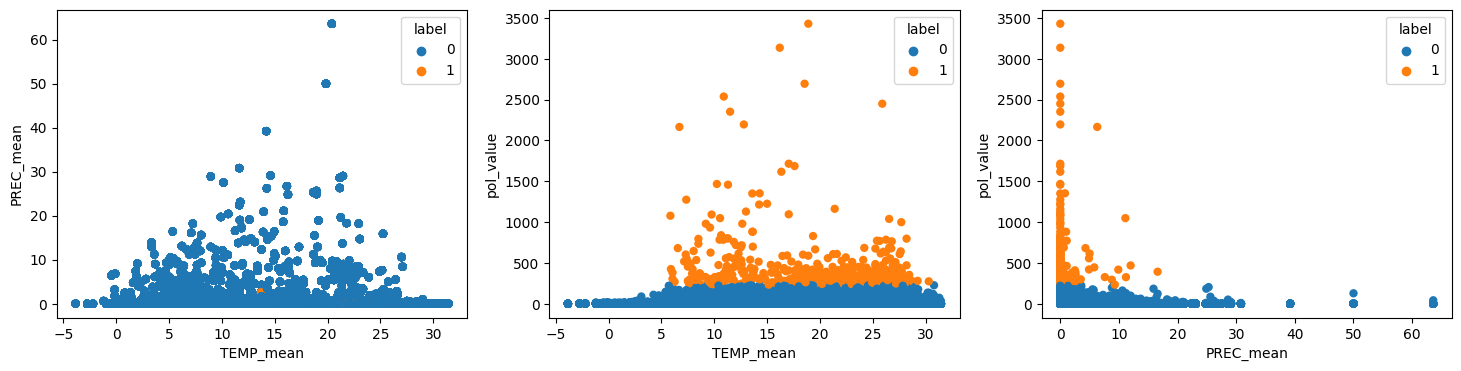

In [154]:
f, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.scatterplot(x='TEMP_mean', y='PREC_mean', data=dataset_df, hue='label', ec=None, ax=axs[0]);
sns.scatterplot(x='TEMP_mean', y='pol_value', data=dataset_df, hue='label', ec=None, ax=axs[1]);
sns.scatterplot(x='PREC_mean', y='pol_value', data=dataset_df, hue='label', ec=None, ax=axs[2]);

In [155]:
### Assign cluster labels
dataset_df["label"] = labels

### Count species, cluster number
species_groups = dataset_df.groupby(["pol_var_id", "label"]).count()

### Sort by count and keep most common cluster
species_groups = species_groups.sort_values("pol_var_id")
species_groups = species_groups.groupby(level=0).tail(1)

species_groups = species_groups.index.values

### Reassign cluster
species_groups = dict(species_groups)
dataset_df.label = dataset_df.pol_var_id.map(species_groups)

species_groups = dataset_df.groupby("label")["pol_var_descr"].apply(list)
species_groups = {key:sorted(set(values)) for key,values in dict(species_groups).items()}

species_groups

{0: ['Altri Pollini / Non Identificati_Pollini non identificati, POLLEN/M**3',
  'Betulacee_Betulla, POLLEN/M**3',
  'Betulacee_Ontano nero, POLLEN/M**3',
  'Cannabacee, POLLEN/M**3',
  'Chenopodiacee - Amarantacee Indistinte_Chenopodiacee - Ama, POLLEN/M**3',
  'Ciperacee_Ciperacee indistinte, POLLEN/M**3',
  'Composite_Ambrosia, POLLEN/M**3',
  'Composite_Artemisia, POLLEN/M**3',
  'Composite_Composite indistinte, POLLEN/M**3',
  'Corilacee_Carpino, POLLEN/M**3',
  'Corilacee_Nocciolo, POLLEN/M**3',
  'Euphorbiacee_Euforbiacee indistinte, POLLEN/M**3',
  'Fagacee_Castagno, POLLEN/M**3',
  'Fagacee_Faggio, POLLEN/M**3',
  'Ippocastanacee_Ippocastanacee indistinte, POLLEN/M**3',
  'Juglandacee_Juglandacee indistinte, POLLEN/M**3',
  'Mirtacee_Mirtacee indistinte, POLLEN/M**3',
  'Moracee - Morus, POLLEN/M**3',
  'Oleacee_Frassino, POLLEN/M**3',
  'Oleacee_Oleacee indistinte, POLLEN/M**3',
  'Oleacee_Olivo, POLLEN/M**3',
  'Plantaginacee_Plantaginacee indistinte, POLLEN/M**3',
  'Poligo

# 4. DBSCAN

In [156]:
from sklearn import metrics
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [157]:
sub_features = [
    'TEMP_min',
    'TEMP_max',
    'TEMP_mean',
    'TEMP_std',
    'PREC_min',
    'PREC_max',
    'PREC_mean',
    'PREC_std',
    'pol_value',
    'station_lat',
    'station_lon'
]

In [158]:
sub_sub_features = [
    'TEMP_mean',
    'TEMP_std',
    'PREC_mean',
    'PREC_std',
    'pol_value',
    'station_lat',
    'station_lon'
]

In [159]:
X = dataset_df[sub_features].copy()
# X = dataset_df[sub_sub_features].copy()

X

,TEMP_min,TEMP_max,TEMP_mean,TEMP_std,PREC_min,PREC_max,PREC_mean,PREC_std,pol_value,station_lat,station_lon
0,2.6,7.6,5.1,2.5,3.2,3.2,3.2,3.2,0.00,44.4914,11.3694
1,2.6,7.6,5.1,2.5,3.2,3.2,3.2,3.2,0.00,44.4914,11.3694
2,2.6,7.6,5.1,2.5,3.2,3.2,3.2,3.2,0.00,44.4914,11.3694
3,2.6,7.6,5.1,2.5,3.2,3.2,3.2,3.2,0.00,44.4914,11.3694
4,2.6,7.6,5.1,2.5,3.2,3.2,3.2,3.2,0.00,44.4914,11.3694
...,...,...,...,...,...,...,...,...,...,...,...
100810,2.4,7.0,4.7,2.3,0.0,0.0,0.0,0.0,0.43,44.6552,11.6231
100811,2.4,7.0,4.7,2.3,0.0,0.0,0.0,0.0,0.00,44.6552,11.6231
100812,2.4,7.0,4.7,2.3,0.0,0.0,0.0,0.0,0.00,44.6552,11.6231
100813,2.4,7.0,4.7,2.3,0.0,0.0,0.0,0.0,0.00,44.6552,11.6231


In [160]:
X_scaled = StandardScaler().fit_transform(X)
# X_scaled = MinMaxScaler().fit_transform(X)

# idxs = np.random.choice(X_scaled.shape[0], int(X_scaled.shape[0]*.2), replace=False)
# X_scaled_sample = X_scaled[idxs]
# X_scaled_sample.shape

In [161]:
# cls = DBSCAN(eps=.5, min_samples=100)
# cls = OPTICS(min_samples=2, n_jobs=10)

cls = KMeans(n_clusters=8)

cls.fit(X_scaled)
# cls.fit(X_scaled_sample)

KMeans()

Estimated number of clusters: 8
Estimated number of noise points: 0
Counter({4: 25247, 0: 19187, 6: 18082, 3: 15591, 1: 14952, 5: 6112, 2: 1170, 7: 357})


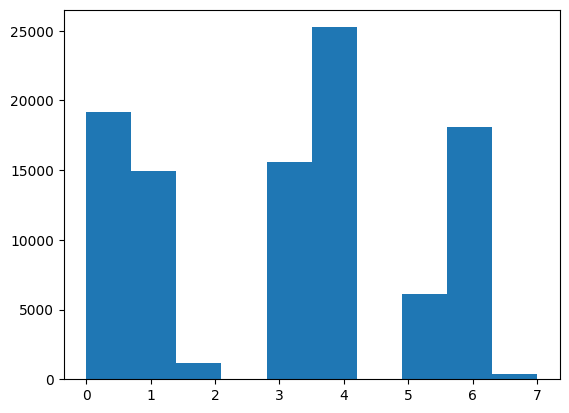

In [162]:
# Number of clusters in labels, ignoring noise if present.
labels = cls.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(Counter(labels))
plt.hist(labels);

# 5. Clustering

In [174]:
df_corr = dataset_df.groupby('station_id').corr()
df_corr

id_gepo  station_lat  station_lon  \
station_id                                                             
1          id_gepo                     NaN          NaN          NaN   
           station_lat                 NaN          NaN          NaN   
           station_lon                 NaN          NaN          NaN   
           station_H_piano_strada      NaN          NaN          NaN   
           station_H_mslm              NaN          NaN          NaN   
...                                    ...          ...          ...   
13         PREC_max                    NaN          NaN          NaN   
           PREC_mean                   NaN          NaN          NaN   
           PREC_std                    NaN          NaN          NaN   
           pol_value                   NaN          NaN          NaN   
           label                       NaN          NaN          NaN   

                                   station_H_piano_strada  station_H_mslm  \
station_id                                                                  
1          id_gepo                                    NaN             NaN   
           station_lat                                NaN             NaN   
           station_lon                                NaN             NaN   
           station_H_piano_strada                     NaN             NaN   
           station_H_mslm                             NaN             NaN   
...                                                   ...             ...   
13         PREC_max                                   NaN             NaN   
           PREC_mean                                  NaN             NaN   
           PREC_std                                   NaN             NaN   
           pol_value                                  NaN             NaN   
           label                                      NaN             NaN   

                                   arkimet_lat  arkimet_lon  meteo_id  \
station_id                                                              
1          id_gepo                         NaN          NaN       NaN   
           station_lat                     NaN          NaN       NaN   
           station_lon                     NaN          NaN       NaN   
           station_H_piano_strada          NaN          NaN       NaN   
           station_H_mslm                  NaN          NaN       NaN   
...                                        ...          ...       ...   
13         PREC_max                        NaN          NaN       NaN   
           PREC_mean                       NaN          NaN       NaN   
           PREC_std                        NaN          NaN       NaN   
           pol_value                       NaN          NaN       NaN   
           label                           NaN          NaN       NaN   

                                   B13011_min    B13011_max  ...  \
station_id                                                   ...   
1          id_gepo                        NaN           NaN  ...   
           station_lat                    NaN           NaN  ...   
           station_lon                    NaN           NaN  ...   
           station_H_piano_strada         NaN           NaN  ...   
           station_H_mslm                 NaN           NaN  ...   
...                                       ...           ...  ...   
13         PREC_max                       NaN  4.751035e-01  ...   
           PREC_mean                      NaN  4.751035e-01  ...   
           PREC_std                       NaN  4.751035e-01  ...   
           pol_value                      NaN -2.158402e-02  ...   
           label                          NaN -6.836922e-17  ...   

                                       TEMP_min      TEMP_max     TEMP_mean  \
station_id                                                                    
1          id_gepo                          NaN           NaN           NaN   
           station_lat  

In [14]:
from scipy.spatial.distance import pdist, squareform

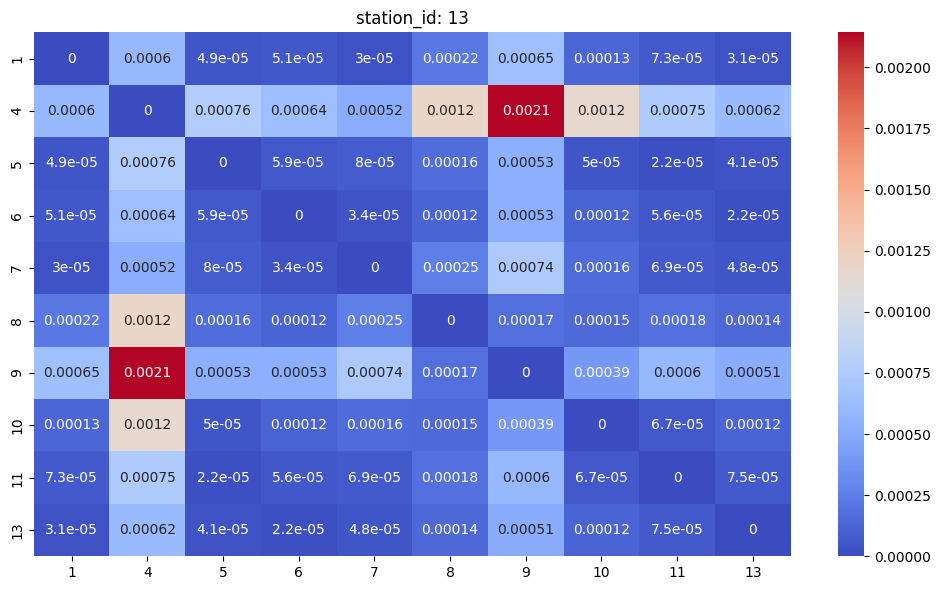

In [271]:
# df = dataset_df.select_dtypes(include=['number']).copy()
df = dataset_df.copy()
df.set_index("station_id", inplace=True)
df = df[species_keys]
# df[df.columns] = pd.DataFrame(MinMaxScaler().fit_transform(df[df.columns]), columns=df.columns, index=df.index)

# Calculate the pairwise distances between stations
grouped = df.groupby('station_id')
distances = pdist(grouped[df.columns].mean(), metric='correlation')
distance_matrix = squareform(distances)

# Convert the distance matrix to a pandas DataFrame
distance_df = pd.DataFrame(distance_matrix, index=grouped.groups.keys(), columns=grouped.groups.keys())

plt.figure(figsize=(10,6))
plt.title(f"station_id: {station_id}")
sns.heatmap(distance_df, cmap='coolwarm', annot=True);
plt.tight_layout();

In [15]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
from itertools import combinations

In [299]:
df = dataset_df.select_dtypes(include=['number']).copy()
df = dataset_df.copy()

In [307]:
# station_species = df[["station_id", "pol_var_id"]].drop_duplicates().values
# station_species = list(map(list, station_species))
# station_species_comb = list(combinations(station_species, 2))
# station_species_comb

In [309]:
dataset_df.station_id.unique()

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 13])

In [310]:
dataset_df.pol_var_id.unique()

array(['B48026', 'B48029', 'B48025', 'B48024', 'B48034', 'B48033',
       'B48037', 'B48036', 'B48030', 'B48032', 'B48031', 'B48021',
       'B48008', 'B48007', 'B48011', 'B48003', 'B48001', 'B48002',
       'B48006', 'B48005', 'B48018', 'B48017', 'B48039', 'B48023',
       'B48019', 'B48013', 'B48012', 'B48016', 'B48015', 'B48066',
       'B48045', 'B48080', 'B48041', 'B48082', 'B48079', 'B48044',
       'B48077', 'B48038', 'B48081'], dtype=object)

In [315]:
station_id = 1

view = df[df.station_id == station_id]

for pol_id in view.pol_var_id.unique():
    
    tocomp = view[view.pol_var_id == ]

In [16]:
# # df[df.columns] = pd.DataFrame(MinMaxScaler().fit_transform(df[df.columns]), columns=df.columns, index=df.index)

# # Calculate the pairwise distances between stations and species
# for (station_id, pol_var_id), group in df.groupby(["station_id", "pol_var_id"]):
    
#     view = df[(df.station_id != station_id) & (df.pol_var_id != pol_var_id)]
    
#     for _, tocompare in view.groupby(["station_id", "pol_var_id"]):
#         distance_matrix = squareform(cdist(view, tocompare))
#         distance_df = pd.DataFrame(distance_matrix, index=grouped.groups.keys(), columns=grouped.groups.keys())

#         plt.figure(figsize=(10,6))
#         plt.title(f"station_id: {station_id}")
#         sns.heatmap(distance_df, cmap='coolwarm', annot=True);
#         plt.tight_layout();
    
#     break

In [289]:
station_id, pol_var_id

(1, 'B48001')

In [292]:
view

,station_id,id_gepo,station_lat,station_lon,station_nome,station_H_piano_strada,station_H_mslm,arkimet_id,arkimet_lat,arkimet_lon,...,PREC_min,PREC_max,PREC_mean,PREC_std,pol_var_id,reftime,pol_value,modified,pol_var_descr,label
14001,4,4182,44.8103,11.5876,Ferrara,8.0,29.0,Ferrara urbana,44.83250,11.6211,...,1.4,1.4,1.4,1.4,B48018,2021-01-03 00:00:00+00:00,0.00,None,"Plantaginacee_Plantaginacee indistinte, POLLEN...",0
14002,4,4182,44.8103,11.5876,Ferrara,8.0,29.0,Ferrara urbana,44.83250,11.6211,...,1.4,1.4,1.4,1.4,B48013,2021-01-03 00:00:00+00:00,0.00,None,"Fagacee_Quercia, POLLEN/M**3",1
14003,4,4182,44.8103,11.5876,Ferrara,8.0,29.0,Ferrara urbana,44.83250,11.6211,...,1.4,1.4,1.4,1.4,B48017,2021-01-03 00:00:00+00:00,0.00,None,"Oleacee_Oleacee indistinte, POLLEN/M**3",0
14004,4,4182,44.8103,11.5876,Ferrara,8.0,29.0,Ferrara urbana,44.83250,11.6211,...,1.4,1.4,1.4,1.4,B48015,2021-01-03 00:00:00+00:00,0.00,None,"Oleacee_Olivo, POLLEN/M**3",0
14005,4,4182,44.8103,11.5876,Ferrara,8.0,29.0,Ferrara urbana,44.83250,11.6211,...,1.4,1.4,1.4,1.4,B48016,2021-01-03 00:00:00+00:00,0.00,None,"Oleacee_Frassino, POLLEN/M**3",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100810,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,0.0,0.0,0.0,0.0,B48008,2021-12-30 00:00:00+00:00,0.43,None,"Corilacee_Nocciolo, POLLEN/M**3",0
100811,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,0.0,0.0,0.0,0.0,B48034,2021-12-30 00:00:00+00:00,0.00,None,"Salicacee_Pioppo, POLLEN/M**3",1
100812,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,0.0,0.0,0.0,0.0,B48041,2021-12-30 00:00:00+00:00,0.00,None,"Spore fungine_Stemphylium, POLLEN/M**3",0
100813,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,0.0,0.0,0.0,0.0,B48023,2021-12-30 00:00:00+00:00,0.00,None,Chenopodiacee - Amarantacee Indistinte_Chenopo...,0


# 5. Only geographic data

In [6]:
dataset_df

,station_id,id_gepo,station_lat,station_lon,station_nome,station_H_piano_strada,station_H_mslm,arkimet_id,arkimet_lat,arkimet_lon,...,TEMP_std,PREC_min,PREC_max,PREC_mean,PREC_std,pol_var_id,reftime,pol_value,modified,pol_var_descr
0,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48026,2021-01-03 00:00:00+00:00,0.00,None,"Mirtacee_Mirtacee indistinte, POLLEN/M**3"
1,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48029,2021-01-03 00:00:00+00:00,0.00,None,"Ulmacee_Ulmacee indistinte, POLLEN/M**3"
2,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48025,2021-01-03 00:00:00+00:00,0.00,None,"Euphorbiacee_Euforbiacee indistinte, POLLEN/M**3"
3,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48024,2021-01-03 00:00:00+00:00,0.00,None,"Poligonacee_Poligonacee indistinte, POLLEN/M**3"
4,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,2.5,3.2,3.2,3.2,3.2,B48034,2021-01-03 00:00:00+00:00,0.00,None,"Salicacee_Pioppo, POLLEN/M**3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100810,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,2.3,0.0,0.0,0.0,0.0,B48008,2021-12-30 00:00:00+00:00,0.43,None,"Corilacee_Nocciolo, POLLEN/M**3"
100811,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,2.3,0.0,0.0,0.0,0.0,B48034,2021-12-30 00:00:00+00:00,0.00,None,"Salicacee_Pioppo, POLLEN/M**3"
100812,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,2.3,0.0,0.0,0.0,0.0,B48041,2021-12-30 00:00:00+00:00,0.00,None,"Spore fungine_Stemphylium, POLLEN/M**3"
100813,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,2.3,0.0,0.0,0.0,0.0,B48023,2021-12-30 00:00:00+00:00,0.00,None,Chenopodiacee - Amarantacee Indistinte_Chenopo...


In [7]:
col_f = ["station_lat", "station_lon", "arkimet_lat", "arkimet_lon"]

In [22]:
dbscan = DBSCAN(eps=.5)

# Fit the clustering model on the latitude and longitude columns
dbscan.fit(dataset_df[col_f])

# Get the cluster labels for each data point
cluster_labels = dbscan.labels_

cluster_labels

array([0, 0, 0, ..., 6, 6, 6])

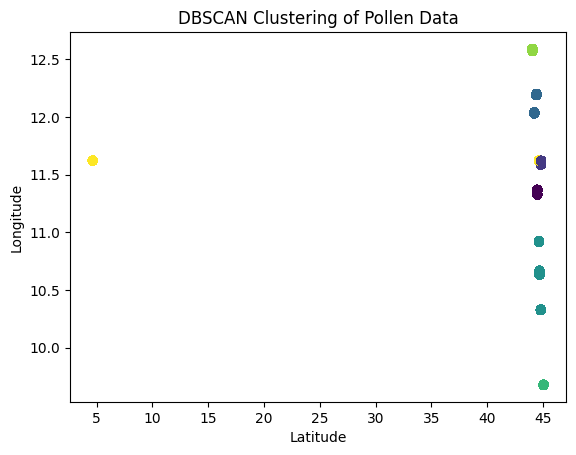

In [23]:
# Plot the clusters on a scatter plot
plt.scatter(dataset_df['station_lat'], dataset_df['station_lon'], c=cluster_labels, cmap='viridis')
plt.scatter(dataset_df['arkimet_lat'], dataset_df['arkimet_lon'], c=cluster_labels, cmap='viridis')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('DBSCAN Clustering of Pollen Data')
plt.show()